In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exps = ['sim','ser']
rois = ['wm','ventricles']
runs = map(str,range(1,4))

#First extract ROIS from noise masks for use in GLM

In [3]:
def extract_roi(in_tuple):
    sub,exp,run,mask = in_tuple
    
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + \
    run + '/'

    #make sure to get coregistered preproc data
    preproc_data = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' \
    + str(run) + '/timeseries_xfm.nii.gz'

    mask_dir = home_dir + 'data/' + sub + '/masks/' 
    out_dir = mask_dir + 'extractions/'
    
    if not os.path.exists(out_dir):
        os.mkdir(mask_dir)

    mask_file = mask_dir + mask + '_' + exp  + '.nii.gz'
    out_f = out_dir + ('').join(map(str,in_tuple))+ '.txt'

    if os.path.exists(sub_path) and not os.path.exists(out_f):
        meants = ImageMeants(in_file = preproc_data, eig = True, order = 1, 
                             mask = mask_file, out_file = out_f)
        meants.run()

In [4]:
in_tuples = []
for sub in sub_list:
    for exp in exps:
        for run in runs:
            for mask in rois:
                in_tuples.append((sub,exp,run,mask))

In [5]:
pool = multiprocessing.Pool(processes = 25)
pool.map(extract_roi,in_tuples)
pool.terminate()
pool.join()

In [5]:
for sub in sub_list:
    for exp in exps:
        noise_rois = {'wm':[],'ventricles':[],'run':[]}
        out_f = home_dir + 'data/' + sub + '/design/noise_regressors_' + exp + '.csv' #out file
        
        for run in runs:
            for n,mask in enumerate(rois):
                
                in_tuple = (sub,exp,run,mask)
                
                ##paths
                sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + \
                run + '/'
                out_dir = home_dir + 'data/' + sub + '/masks/extractions/' 

                #get data
                if os.path.exists(sub_path):
                    data_f = out_dir + ('').join(map(str,in_tuple))+ '.txt'
                    data = np.loadtxt(data_f)
                    noise_rois[mask].extend(data)
                    if n > 0: #only add run once per iteration through all masks
                        noise_rois['run'].extend([run]*len(data))
        
        noise_rois = pd.DataFrame(noise_rois)
        
        ##write output
        noise_rois.to_csv(out_f, header=True,index = False, columns = ['wm','ventricles','run'])


#Next extract tsnr from lyman outputs

In [3]:
all_rois = {'ser':["lOFC_fill_ser", "mOFC_fill_ser","V1_fill_ser"],
            'sim':["lOFC_fill_sim", "mOFC_fill_sim","V1_fill_sim"]}
in_tuples = []
for sub in sub_list:
    for exp in exps:
        for run in runs:
            rois = all_rois[exp]
            for mask in rois:
                in_tuples.append((sub,exp,run,mask))

In [14]:
#extract tsnr of ROIs
def extract_tsnr(in_tuple):
    sub,exp,run,mask = in_tuple
    tsnr = np.nan
    tsnr_f = home_dir + 'analysis/' + exp + '_8mm-PEfb/' + sub + \
        '/model/smoothed/run_' + str(run) + '/tsnr.nii.gz'
        
    if os.path.exists(tsnr_f):
        
        mask_dir = home_dir + 'data/' + sub + '/masks/' 
        mask_file = mask_dir + mask + '.nii.gz'

        stats = ImageStats(in_file = tsnr_f, op_string = '-k %s -M', mask_file = mask_file)
        out = stats.run()
        tsnr = out.outputs.out_stat
    
    return (sub,exp,run,mask,tsnr)

In [27]:
pool = multiprocessing.Pool(processes = 25)
out = pool.map(extract_tsnr,in_tuples)
pool.terminate()
pool.join()

In [25]:
tsnr_df = {'roi':[],'tsnr':[],'run':[],'sub':[],'exp':[]}
for o in out:
    sub,exp,run,mask,tsnr = o

    tsnr_df['roi'].append(mask.split('_')[0])
    tsnr_df['sub'].append(sub)
    tsnr_df['run'].append(run)
    tsnr_df['exp'].append(exp)
    tsnr_df['tsnr'].append(tsnr)
tsnr_df = pd.DataFrame(tsnr_df)

In [30]:
 tsnr_df.groupby(['roi'])


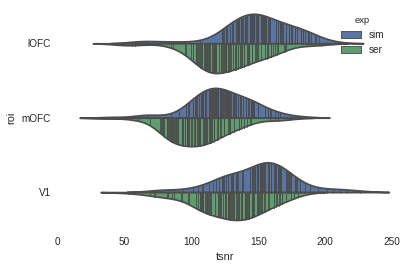

In [52]:
sns.violinplot(x='tsnr',y='roi',hue='exp',data=tsnr_df,split=True,inner = 'stick')